In [2]:
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI

from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from typing_extensions import Annotated, TypedDict
from typing import Callable, Literal, Optional, Sequence, Type, TypeVar, Union, cast
from langchain_core.messages import AIMessage, BaseMessage, SystemMessage, ToolMessage
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph
from langgraph.prebuilt.tool_node import ToolNode, tools_condition
from langgraph.graph import MessagesState, START, END
from langgraph.types import Command
from langchain_core.messages import HumanMessage, AIMessage
from pydantic import BaseModel
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.tools import tool

In [4]:
from sql_react_agent import nl2sql_tool, get_schema_info

/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/sql_react_agent.py:186: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 1.0. Use :meth:`~invoke` instead.
  print(nl2sql_tool("I want to know the top ethnicities with the most part time employees"))


INSIDE NL2SQL TOOL


RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}

##### LLM init

In [3]:
llm = ChatOpenAI(model="gpt-4")

##### Agent State and Setup

In [4]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]


def create_agent(llm, tools):
    llm_with_tools = llm.bind_tools(tools)
    def chatbot(state: AgentState):
        return {"messages": [llm_with_tools.invoke(state["messages"])]}

    graph_builder = StateGraph(AgentState)
    graph_builder.add_node("agent", chatbot)

    tool_node = ToolNode(tools=tools)
    graph_builder.add_node("tools", tool_node)

    graph_builder.add_conditional_edges(
        "agent",
        tools_condition,
    )
    graph_builder.add_edge("tools", "agent")
    graph_builder.set_entry_point("agent")
    return graph_builder.compile()



In [5]:
schema = get_schema_info()

#### Clarify query

In [ ]:

class ClarifyToolSchema(BaseModel):
    question: str

def create_clarify_chain(llm, schema: str):
    system_prompt = f"""
You are a helpful assistant responsible for clarifying user queries related to a Microsoft SQL Server database.

Here is the database schema:

{schema}

Your job is to rewrite the user query using the correct table and column names from the schema.
Make the query as specific and unambiguous as possible while preserving the user's intent.
Do not write an SQL query, just clarify the user's question using the schema information.
For example, if the user asks "What is the average salary?", you might clarify it as "What is the average salary of employees in the Employees table?".
"""

    def clarify(question: str):
        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=question)
        ]
        return llm.invoke(messages).content

    return RunnableLambda(lambda x: clarify(x["question"]))

def clarify_tool_factory(llm, schema: str):
    clarify_chain = create_clarify_chain(llm, schema)

    @tool(args_schema=ClarifyToolSchema)
    def clarify_query_tool(question: str) -> str:
        """Clarifies a natural language query by making it schema-aware."""
        print("INSIDE CLARIFY TOOL")
        return clarify_chain.invoke({"question": question})

    return clarify_query_tool

In [12]:
clarify_tool = clarify_tool_factory(llm, schema)

##### SQL Sub-agent

In [23]:
nl2sql_agent = create_agent(ChatOpenAI(model="gpt-4"), [nl2sql_tool])

def nl2sql_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = nl2sql_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="nl2sql")
            ]
        },
        goto="supervisor",
    )

#### Clarify agent

In [15]:
clarify_agent = create_agent(ChatOpenAI(model="gpt-3.5-turbo-16k"), [clarify_tool])

def clarify_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    result = clarify_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="clarify")
            ]
        },
        goto="supervisor",
    )

#### Setting up Supervisor

In [18]:
# Define available agents
members = ["nl2sql", "clarify"]
# Add FINISH as an option for task completion
options = members + ["FINISH"]


In [19]:
system_prompt = (
   """
You are a supervisor agent named "SQL Orchestrator" tasked with managing a conversation between the following workers: {members}.
Your role is to interpret user queries and delegate tasks to the appropriate worker based on the query's intent.

Here is the database schema for your reference:
{schema}

Your responsibilities:
1. If the user's query is ambiguous or does not clearly refer to tables or fields in the schema, route the query to the "clarify" worker first. It will rephrase the query using the database schema and return a clearer version.
2. If the query is already clear and directly maps to the schema, route it to "nl2sql", which is capable of generating and executing SQL queries and returning results.
3. Always think about wether to clarify the query, but ALWAYS then route to the "nl2sql" worker to obtain the results.
4. Wait for the "nl2sql" agent to respond with the SQL query and/or its result.
5. When returning the result to the user, include the column names and their data types. If the result is empty, mention that explicitly.
6. Only delegate when necessary. When the task is complete and no further action is required, respond with `FINISH`.
"""
)

In [23]:
# SUPERVISOR_PROMPT = """
# You are a supervisor agent named "SQL Orchestrator". You are responsible for delegating user queries to a sub-agent called "sql_react_agent", which is capable of interacting with a Microsoft SQL Server database and returning query results.

# Your job is to:
# 1. Interpret the user's query and determine if it involves retrieving data from the database.
# 2. Delegate that task to the "SQL Agent".
# 3. Once the SQL Agent finishes its execution, analyze its full output history.
# 4. From the output, extract:
#    - The final result set returned by the SQL Agent.
#    - The **column names** in the result.
#    - The **data types** of those columns (if available or inferable).
#    - How those columns and their values relate to the user's original question.

# Only summarize information actually present in the SQL Agent's output — do not guess or fabricate columns, types, or values.

# If no relevant information is found in the SQL Agent's output, reply that there was not enough information to answer the question.
# """

# SUPERVISOR_PROMPT = """
# You are a supervisor agent named "SQL Orchestrator". You are responsible for delegating user queries to a sub-agent called "sql_react_agent", which is capable of interacting with a Microsoft SQL Server database and returning query results.

# Your job is to:
# 1. Interpret the user's query and determine if it involves retrieving data from the database.
# 2. Delegate that task to the "SQL Agent".

# If no relevant information is found in the SQL Agent's output, reply that there was not enough information to answer the question.
# """

In [20]:
# Define router type for structured output
class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal["nl2sql", "clarify", "FINISH"]

In [21]:
# Create supervisor node function
def supervisor_node(state: MessagesState) -> Command[Literal["nl2sql", "clarify", "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    print(f"Next Worker: {goto}")
    if goto == "FINISH":
        goto = END
    return Command(goto=goto)

In [24]:
builder = StateGraph(MessagesState)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("nl2sql", nl2sql_node)
builder.add_node("clarify", clarify_node)
graph = builder.compile()

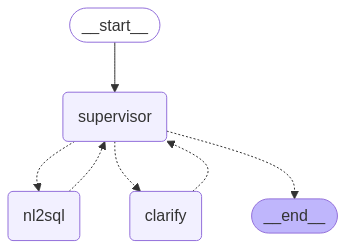

In [25]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # You can put your exception handling code here
    pass


In [26]:
# Example: Complex Query Using Multiple Agents
input_question = "Can you give me the name and prices of 3 most popular products in 2008"
for s in graph.stream(
    {"messages": [("user", input_question)]}, 
    subgraphs=True
):
    print(s)
    print("----")


/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/langgraph-supervisor/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: clarify
((), {'supervisor': None})
----
INSIDE CLARIFY TOOL(('clarify:d29a9c41-2d24-1903-c11d-72851be1efc2',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5i2FQ07CkV7yRAA1GfjKLoTJ', 'function': {'arguments': '{\n  "question": "top 3 most popular products in 2008"\n}', 'name': 'clarify_query_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 70, 'total_tokens': 98, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-16k-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BJq4D1XDIN69OJ5vBMcBew0c1BvCC', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0d2160de-afd7-4ef0-83a0-e976f2471b7c-0', tool_calls=[{'name': 'clarify_query_tool', 'args': {'question': 'top 3 most 

/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/langgraph-supervisor/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: nl2sql
((), {'supervisor': None})
----
INSIDE NL2SQL TOOL(('nl2sql:ddadeb77-3f7f-fce0-99ce-48e936c9ed8f',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_o7FjpcQBvkW6dY82wdsrhkHy', 'function': {'arguments': '{\n  "question": "Can you give me the name and prices of 3 most popular products in 2008"\n}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 35, 'prompt_tokens': 267, 'total_tokens': 302, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BJq4TZt4V0tKuxDSIqWqDyN6u3ecX', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-961cd263-70af-4e4e-8264-9797c2e32d40-0', tool_calls=[{'name': 'nl2sql_tool', 'args': {'question': 'Can

/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/langgraph-supervisor/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: FINISH
((), {'supervisor': None})
----


In [27]:
input_question = "I want to know the highest profitable sales order of all time"
result = graph.invoke(
    {"messages": [("user", input_question)]}
)

/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/langgraph-supervisor/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: clarify
INSIDE CLARIFY TOOL


/Users/mehulmathur/AI Projects/Langgraph-Supervisor-SQL-Agent/langgraph-supervisor/lib/python3.13/site-packages/langchain_openai/chat_models/base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


Next Worker: nl2sql
INSIDE NL2SQL TOOL
Query Execution Result: [(71784, Decimal('119960.8240'))]
Chain Response: {'question': 'What is the highest profitable sales order of all time?', 'query': 'SELECT TOP 1 [SalesOrderID], MAX([SubTotal] + [TaxAmt] + [Freight]) as [HighestProfit] \nFROM [SalesLT].[SalesOrderHeader] \nGROUP BY [SalesOrderID] \nORDER BY [HighestProfit] DESC', 'result': "[(71784, Decimal('119960.8240'))]"}


RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4 in organization org-vmt5O4SCmfAsWJWS68XkgySg on tokens per min (TPM): Limit 10000, Used 9866, Requested 484. Please try again in 2.1s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [28]:
result

NameError: name 'result' is not defined

In [56]:
orchestrator_agent = create_supervisor(
    agents=[SQL_REACT_AGENT],
    model=llm,
    prompt=(
        SUPERVISOR_PROMPT
    ),
    output_mode="last_message",
    # output_mode="full_history",
    supervisor_name="SQL_Orchestrator"
)

In [48]:
main_app = orchestrator_agent.compile()

In [49]:
main_app.get_graph()

Graph(nodes={'__start__': Node(id='__start__', name='__start__', data=<class 'langchain_core.utils.pydantic.LangGraphInput'>, metadata=None), 'SQL_Orchestrator': Node(id='SQL_Orchestrator', name='SQL_Orchestrator', data=<langgraph.graph.state.CompiledStateGraph object at 0x12098efd0>, metadata=None), 'sql_react_agent': Node(id='sql_react_agent', name='sql_react_agent', data=call_agent(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None), '__end__': Node(id='__end__', name='__end__', data=<class 'langchain_core.utils.pydantic.LangGraphOutput'>, metadata=None)}, edges=[Edge(source='__start__', target='SQL_Orchestrator', data=None, conditional=False), Edge(source='sql_react_agent', target='SQL_Orchestrator', data=None, conditional=False), Edge(source='SQL_Orchestrator', target='sql_react_agent', data=None, conditional=True), Edge(source='SQL_Orchestrator', target='__end__', data=None, conditional=True)])

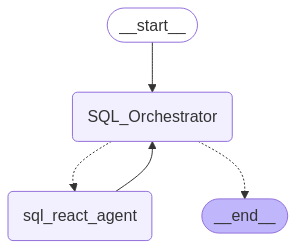

In [50]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        main_app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [57]:
res = main_app.invoke(
    {"messages": [HumanMessage(content="What are the top 3 most popular product categories")]}
)

res




{'messages': [HumanMessage(content='What are the top 3 most popular product categories', additional_kwargs={}, response_metadata={}, id='fd586410-3923-4005-820d-4b386b9f3e48'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_JcRAJV0yLf8YVKebINmiBL70', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_react_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 269, 'total_tokens': 281, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BJQ9uwdakdEV1jn9qzTsIf7hGyHv7', 'finish_reason': 'tool_calls', 'logprobs': None}, name='SQL_Orchestrator', id='run-157af403-7138-4fb7-ac34-8728cb2079e6-0', tool_calls=[{'name': 'transfer_to_sql_react_agent', 'args': {}, 'id': 'call_

In [ ]:
temp = nl2sql_agent.invoke(
    {"messages": [HumanMessage(content="What are the top 3 most popular product categories")]}
)

temp

{'messages': [HumanMessage(content='What are the top 3 most popular product categories', additional_kwargs={}, response_metadata={}, id='43a1ea5e-0425-4e7f-87be-9733c4fa7eed'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_x7PnNUKRDd8INviQuW1VmIqd', 'function': {'arguments': '{\n  "question": "What are the top 3 most popular product categories"\n}', 'name': 'nl2sql_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 62, 'total_tokens': 89, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4-0613', 'system_fingerprint': None, 'id': 'chatcmpl-BJSQh2odzgPpxQLFCTtVwl24vuJPd', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c7c38b46-ed5d-47b3-b8d8-30e891aa7992-0', tool_calls=[{'name': 'nl2sql_tool', 'args': {'que

In [24]:
# result = main_app.invoke(
#     {"messages": [("user", "Can you give me the top 5 Sales orders by quantity?")]}
# )


from langchain_core.messages import BaseMessage, HumanMessage

query="Can you give me the top 5 Sales orders by quantity?"

events = main_app.stream(
     {"messages": [HumanMessage(content=query)]},
     stream_mode="values",
)

for event in events:
   print(event)
#    message_content= event["messages"][-1].content
#    if "Answer:" in message_content:
#       final_answer=message_content.split("Answer:",1)[1].strip()

result

{'messages': [HumanMessage(content='Can you give me the top 5 Sales orders by quantity?', additional_kwargs={}, response_metadata={}, id='cd660483-d43c-41eb-a35e-02e1b5d8b744')]}
{'messages': [HumanMessage(content='Can you give me the top 5 Sales orders by quantity?', additional_kwargs={}, response_metadata={}, id='cd660483-d43c-41eb-a35e-02e1b5d8b744'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_2BvpXI7PEZFw2Qen9kTGoYeS', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_react_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 272, 'total_tokens': 287, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJPyjHTboIAD3HlGLzbGnxhoVJLf3', 'finish_reason

{'messages': [HumanMessage(content='What is the average salary of employees in the Sales department?', additional_kwargs={}, response_metadata={}, id='dbc1f029-8773-4217-b97b-8bc1262119c8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_tX4dGr1gXhTXHN8qKGcEBDkH', 'function': {'arguments': '{}', 'name': 'transfer_to_sql_react_agent'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 271, 'total_tokens': 286, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BJPmyl9qhikFEEfna7bv3uRu9LhwX', 'finish_reason': 'tool_calls', 'logprobs': None}, name='SQL_Orchestrator', id='run-861f69d3-6deb-40ce-8a0a-b127b2923ec7-0', tool_calls=[{'name': 'transfer_to_sql_react_agent', 'a

In [38]:

from langchain_core.messages import BaseMessage, HumanMessage

query="What are the top 3 most popular product categories"

events = SQL_REACT_AGENT.stream(
     {"messages": [HumanMessage(content=query)]},
     stream_mode="values",
)

for event in events:
   event["messages"][-1].pretty_print()
   message_content= event["messages"][-1].content
   if "Answer:" in message_content:
      final_answer=message_content.split("Answer:",1)[1].strip()

================================ Human Message =================================

What are the top 3 most popular product categories
================================== Ai Message ==================================
Name: sql_react_agent

In order to answer that, I would need to execute a query on the database. Before making a query, I need to know the structure of your database. Let's start by getting the list of tables from your database.
Tool Calls:
  sql_db_list_tables (call_HOdTjkwITEAbYNeF8rdbd7yq)
 Call ID: call_HOdTjkwITEAbYNeF8rdbd7yq
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

Address, Customer, CustomerAddress, Product, ProductCategory, ProductDescription, ProductModel, ProductModelProductDescription, SalesOrderDetail, SalesOrderHeader
================================== Ai Message ==================================
Name: sql_react_agent

The database has tables like Product, ProductCategory, SalesOrderDetai